In [1]:
using DataFrames, FileIO, DelimitedFiles
using Plots, Optim, LsqFit

In [25]:
function read_pop_file(filename, resnames)
    deprotonated_fraction =  Array{Float64, 1}(undef, length(resnames))
    pop_file = readdlm(filename, header = true)[1][2:end, 2:end]

    k = 0
    for resname in resnames
        k+=1
        if resname == "GL4"
            deprotonated_fraction[k] = pop_file[k, 3:end][1]
        elseif resname == "AS4"
            deprotonated_fraction[k] = pop_file[k, 3:end][1]
        elseif resname == "HIP"
            deprotonated_fraction[k] = 1 - pop_file[k, 3:end][1]
        elseif resname == "LYS"
            deprotonated_fraction[k] = 1 - pop_file[k, 3:end][1]
        elseif resname == "CYX"
            deprotonated_fraction[k] = 1 - pop_file[k, 3:end][1]
        elseif resname == "TYR"
            deprotonated_fraction[k] = 1 - pop_file[k, 3:end][1]
        end
    end
    
    return deprotonated_fraction
end

read_pop_file (generic function with 2 methods)

In [22]:
# Get ready
home = "/home/pbarletta/labo/20/cph_obp/"
apo_cph_out = string(home, "run/apo/pdt/cph_outputs/")
apo_cph_pre_out = string(home, "run/apo/pre_pdt/cph_outputs/")

phs = collect(30:5:75)
pdt_steps = collect(0:1:7)
suffix_pka_file = "_pka"
suffix_pop_file = "_pop"
titrable_cnt = 36
titrable_resis = [4, 5, 7, 11, 13, 18, 20, 24, 27, 30, 33, 37, 39,
    40, 41, 42, 48, 52, 58, 59, 64, 69, 73, 77, 78, 82, 87, 93, 94,
    97, 99, 102, 109, 111, 114, 117];
titrable_resnames = ["GL4", "GL4", "LYS", "HIP", "GL4", "LYS", "GL4", "AS4", "LYS",
    "AS4", "GL4", "AS4", "GL4", "AS4", "LYS", "LYS", "GL4", "LYS",
    "AS4", "LYS", "LYS", "LYS", "GL4", "AS4", "GL4", "LYS", "AS4",
    "GL4", "GL4", "HIP", "LYS", "LYS", "LYS", "LYS", "LYS", "AS4"]
global const def_pka_as4 = 3.71
global const def_pka_gl4 = 4.15
global const def_pka_lys = 10.67
global const def_pka_hip = 6.04;
# global const def_pka_cyx = 8.14;
# global const def_pka_tyr = 10.1;

## Leo los \_pop files de todas las corridas

In [41]:
# Obtengo las poblaciones deprotonadas de c/ residuo a c/ valor de pH
# Leo el State 0 de c/ residuo. P/ lods residuos ácidos (GL4, AS4)
# el state 0 es deprotonado, p/ los básicos es protonado.
# Usaré estas poblaciones p/ ajustar la curva de Hill y obtener el valor de pKa.

deprotonated_fractions =  Array{Array{Float64, 2}, 1}(undef, 8)

for j in pdt_steps
    deprotonated_fraction =  Array{Float64, 2}(undef, titrable_cnt, length(phs))
    for i in 1:length(phs)
        if j == 0
            pop_filename = string(apo_cph_pre_out, phs[i], suffix_pop_file)
        else
            pop_filename = joinpath(apo_cph_out, string("p", pdt_steps[j+1]),
                    string(phs[i], suffix_pop_file))
        end
        deprotonated_fraction[:, i] = read_pop_file(pop_filename, titrable_resnames)
    end
    
    deprotonated_fractions[j+1] = deprotonated_fraction
end

### Compilo todas las fracciones desprotonadas de las 8 corridas en 1 sola

In [104]:
deprotonated_fraction =  Array{Float64, 2}(undef, titrable_cnt, length(phs))
for j in pdt_steps
    if j == 0
        # pre_pdt duró 20ns
        deprotonated_fraction = deprotonated_fractions[1] * .1
    else
        # p1-p7 duraron 25 ns c/u
        deprotonated_fraction += deprotonated_fractions[j+1] * .125
    end
end

In [101]:
deprotonated_fraction = deprotonated_fractions[8]

36×10 Array{Float64,2}:
 0.095034  0.205653  0.391753  0.623519  …  0.957335  0.980496  0.993496
 0.235694  0.301599  0.431282  0.610479     0.989568  0.995968  0.998824
 7.2e-5    0.00036   0.000928  0.0012       0.000424  0.001328  0.003504
 0.00464   0.009752  0.020312  0.036721     0.569942  0.761466  0.886117
 0.08433   0.09749   0.1459    0.271735     0.968295  0.988752  0.996112
 0.000776  0.005616  0.014392  0.008584  …  0.024297  0.055545  0.129427
 0.0056    0.01672   0.047985  0.118203     0.901926  0.962551  0.98648
 0.699361  0.847596  0.92895   0.966655     0.998736  0.999608  0.9998
 0.000448  0.00024   0.000264  0.000584     0.007528  0.0124    0.024681
 0.184964  0.386305  0.569958  0.735514     0.984736  0.995344  0.998488
 0.300031  0.42701   0.561789  0.616951  …  0.932886  0.972711  0.98996
 0.625423  0.693569  0.736282  0.792995     0.977023  0.99228   0.99672
 0.112915  0.176308  0.211573  0.256062     0.92299   0.968879  0.9842
 ⋮                                

## Leo los \_pka files, sólo de pre_pdt

In [4]:
# P/ ajustar bien la curva de Hill y obtener los parámetros n y pKa conviene
# empezar con unos buenos parámetros iniciales. P/ n eso es 1.0 y p/ pKa será
# el valor de pKa predicho durante la corrida con menor Offset. Por eso leo
# estos archivos de _pka, p/ obtener los pka predichos y sólo usar el q venga
# con de la corrida con menor offset. Cualquier cosa: ver papers de Swails.

res_offset_all = Array{Float64, 2}(undef, titrable_cnt, length(phs))
res_pka_pred_all = Array{Float64, 2}(undef, titrable_cnt, length(phs))
res_pka_pred =  Array{Float64, 1}(undef, titrable_cnt)

for i = 1:length(phs)
    pka_file = readdlm(string(apo_cph_pre_out, phs[i], suffix_pka_file),
        header = true)[1][1:end-1, 1:end-1]    
    res_offset_all[:, i] = pka_file[:, 5]
    res_pka_pred_all[:, i] = pka_file[:, 7]
end

for i = 1:titrable_cnt
    min_offset_idx = findmin(abs.(res_offset_all[i, :]))[2]
    res_pka_pred[i] = res_pka_pred_all[i, min_offset_idx]
end

## Determino Hill coefficients and pKas

In [105]:
# Hill coefficient and pKa for each residue 
res_pka =  Array{Tuple{Float64, Float64}, 1}(undef, titrable_cnt)

# Hill function
@. f(x, hill_coef) = 1 / (1 + 10 ^(hill_coef[1]*(hill_coef[2] - x)) )
xdata = phs ./ 10

# Fit the curves
for i = 1:titrable_cnt
    hill_coef = [1. ; res_pka_pred[i]]
    fit = curve_fit(f, xdata, deprotonated_fraction[i, :], hill_coef)    
    res_pka[i] = (fit.param[1], fit.param[2])
end

# Guardo los pkas obtenidos
# writetable(string(home, "rtdos_log/pka_apo"), df_titrable_apo, separator = '\t');

### Plotteo

In [55]:
function titration_curve(n, pKa, x)
    return (1 / (1 + 10 ^(n*(pKa - x))))
end
x = collect(1:.1:14);

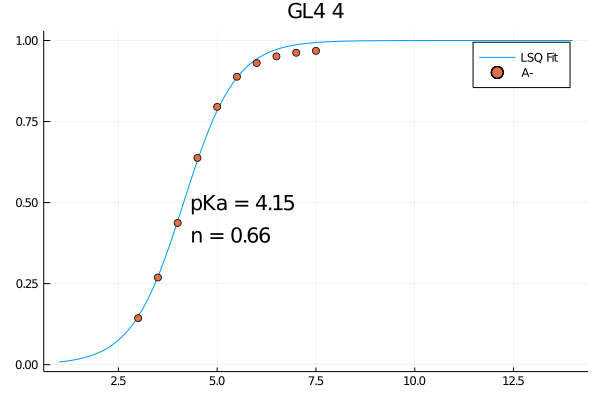

In [106]:
i = 1
plot(x, titration_curve.(res_pka[i][1], res_pka[i][2], x),
    label = "LSQ Fit",
    title = string(titrable_resnames[i], " ", titrable_resis[i]))

scatter!(xdata, deprotonated_fraction[i, :],
    label = "A-")

annotate!((res_pka[i][2] + 1.5), .5, 
    Plots.text(string("pKa = ", round(res_pka[i][2], digits = 2))))
annotate!((res_pka[i][2] + 1.2), .4, 
    Plots.text(string("n = ", round(res_pka[i][1], digits = 2))))

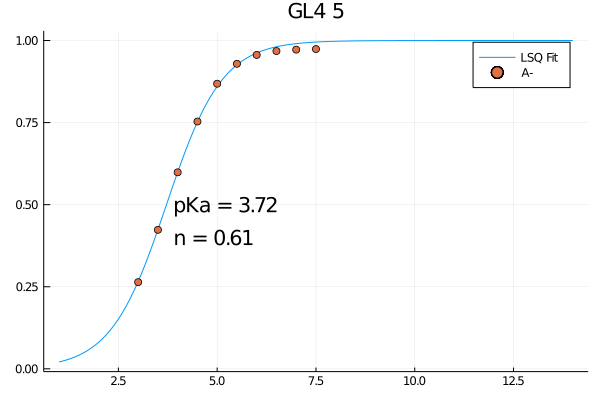

In [76]:
i = 2
plot(x, titration_curve.(res_pka[i][1], res_pka[i][2], x),
    label = "LSQ Fit",
    title = string(titrable_resnames[i], " ", titrable_resis[i]))

scatter!(xdata, deprotonated_fraction[i, :],
    label = "A-")

annotate!((res_pka[i][2] + 1.5), .5, 
    Plots.text(string("pKa = ", round(res_pka[i][2], digits = 2))))
annotate!((res_pka[i][2] + 1.2), .4, 
    Plots.text(string("n = ", round(res_pka[i][1], digits = 2))))

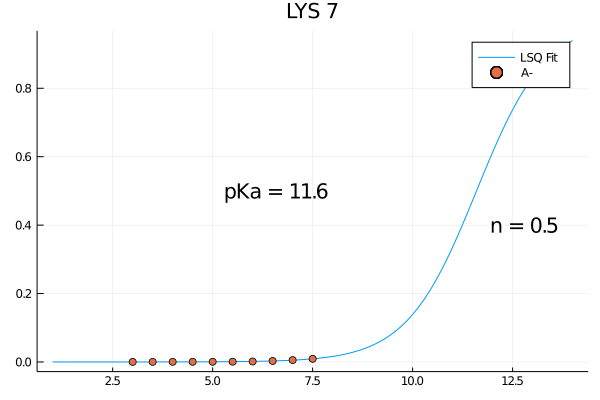

In [75]:
i = 3
plot(x, titration_curve.(res_pka[i][1], res_pka[i][2], x),
    label = "LSQ Fit",
    title = string(titrable_resnames[i], " ", titrable_resis[i]))

scatter!(xdata, deprotonated_fraction[i, :],
    label = "A-")

annotate!((res_pka[i][2] - 5.), .5, 
    Plots.text(string("pKa = ", round(res_pka[i][2], digits = 2))))
annotate!((res_pka[i][2] + 1.2), .4, 
    Plots.text(string("n = ", round(res_pka[i][1], digits = 2))))

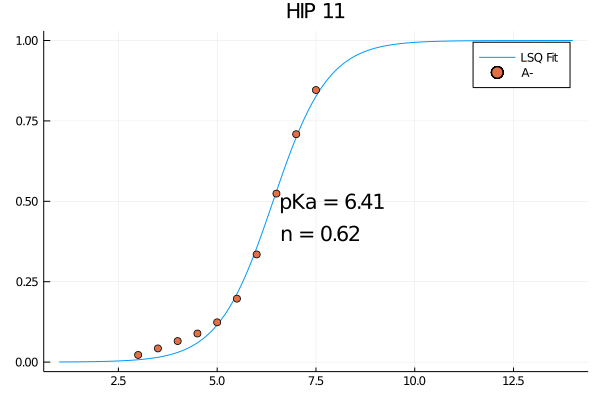

In [74]:
i = 4
plot(x, titration_curve.(res_pka[i][1], res_pka[i][2], x),
    label = "LSQ Fit",
    title = string(titrable_resnames[i], " ", titrable_resis[i]))

scatter!(xdata, deprotonated_fraction[i, :],
    label = "A-")

annotate!((res_pka[i][2] + 1.5), .5, 
    Plots.text(string("pKa = ", round(res_pka[i][2], digits = 2))))
annotate!((res_pka[i][2] + 1.2), .4, 
    Plots.text(string("n = ", round(res_pka[i][1], digits = 2))))

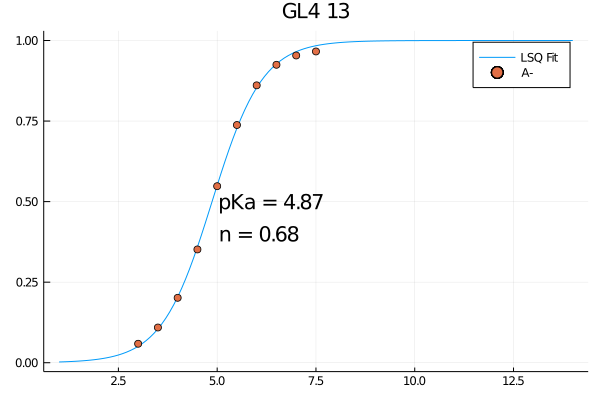

In [71]:
i = 5
plot(x, titration_curve.(res_pka[i][1], res_pka[i][2], x),
    label = "LSQ Fit",
    title = string(titrable_resnames[i], " ", titrable_resis[i]))

scatter!(xdata, deprotonated_fraction[i, :],
    label = "A-")

annotate!((res_pka[i][2] + 1.5), .5, 
    Plots.text(string("pKa = ", round(res_pka[i][2], digits = 2))))
annotate!((res_pka[i][2] + 1.2), .4, 
    Plots.text(string("n = ", round(res_pka[i][1], digits = 2))))

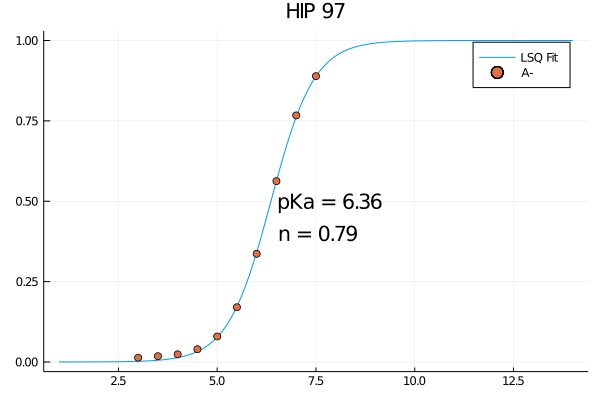

In [73]:
i = 30
plot(x, titration_curve.(res_pka[i][1], res_pka[i][2], x),
    label = "LSQ Fit",
    title = string(titrable_resnames[i], " ", titrable_resis[i]))

scatter!(xdata, deprotonated_fraction[i, :],
    label = "A-")

annotate!((res_pka[i][2] + 1.5), .5, 
    Plots.text(string("pKa = ", round(res_pka[i][2], digits = 2))))
annotate!((res_pka[i][2] + 1.2), .4, 
    Plots.text(string("n = ", round(res_pka[i][1], digits = 2))))

In [63]:
res_pka[i][1]

0.7915998545710683